In [170]:
import numpy as np
import scipy
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix
import sys
import time
import matplotlib.pyplot as plt
import pickle

In [92]:
def inputdata(fnameR, nod, nfree):  #データパス, 要素節点数, 自由度
    f = open(fnameR, 'r')
    text = f.readline()  # コメント
    text = f.readline()  # 1行ずつ読み込む
    text = text.strip()  # 端の空白, 改行(\n)を削除
    text = text.split()  # ' '　で別れた要素ごとの配列にする
    npoin = int(text[0])  # ノード数
    nele = int(text[1])  # 要素数
    npfix = int(text[2])  # 拘束点数
    nlod = int(text[3])  # 荷重点数
    delta_t = float(text[4])  # 微小時間
    n_t = int(text[5])  # 微小時間数
    # 配列宣言
    ae = np.zeros((9, nele), dtype=np.float64)  # 要素特性
    node = np.zeros((nod + 1, nele), dtype=np.int)  # 要素構成節点
    x = np.zeros((3, npoin), dtype=np.float64)  # 座標
    mpfix = np.zeros((nfree, npoin), dtype=np.int)  # 拘束状態
    rdis = np.zeros((nfree, npoin), dtype=np.float64)  # 既知変位
    fp = np.zeros((nfree * npoin), dtype=np.float64)  # 外力
    
    # 要素特性: ae
    text = f.readline()  # コメント
    text = f.readline()
    text = text.strip().split()
    for i in range(0, nele):                
        ae[0, i] = float(text[0])  # A
        ae[1, i] = float(text[1])  # I11
        ae[2, i] = float(text[2])  # I12
        ae[3, i] = float(text[3])  # I22
        ae[4, i] = float(text[4])  # J
        ae[5, i] = float(text[5])  # E
        ae[6, i] = float(text[6])  # G
        ae[7, i] = float(text[7])  # density
    
    # 要素構成節点: node
    text = f.readline()  # コメント   
    for i in range(0, nele):
        text = f.readline()
        text = text.strip().split()
        node[0, i] = int(text[0])  #node_1
        node[1, i] = int(text[1])  #node_2
        node[2, i] = int(text[2])  #要素番号            

    # 座標: x
    text = f.readline()  # コメント    
    for i in range(0, npoin):
        text = f.readline()
        text = text.strip().split()
        x[0, i] = float(text[0])  # x-座標
        x[1, i] = float(text[1])  # y-座標
        x[2, i] = float(text[2])  # z-座標
    
    # 要素質量を計算
    for i in range(0, nele):
        node1_x = x[0, i]
        #         node1_y = x[1, i]
        #         node1_z = x[2, i]
        node2_x = x[0, i + 1]
        #         node2_y = x[1, i+1]
        #         node2_z = x[2, i+1]
        A = ae[0, i]
        density = ae[7, i]
        ae[8, i] = abs(node1_x - node2_x) * A * density        

    # 境界条件（拘束状態） (0:free, 1:restricted)
    text = f.readline()  # コメント    
    for i in range(0, npfix):
        text = f.readline()
        text = text.strip()
        text = text.split()
        lp = int(text[0])  # 固定されたノード番号
        mpfix[0, lp - 1] = int(text[1])  # x方向固定
        mpfix[1, lp - 1] = int(text[2])  # y方向固定
        mpfix[2, lp - 1] = int(text[3])  # z方向固定
        mpfix[3, lp - 1] = int(text[4])  # x軸回転固定
        mpfix[4, lp - 1] = int(text[5])  # y軸回転固定
        mpfix[5, lp - 1] = int(text[6])  # z軸回転固定
        rdis[0, lp - 1] = float(text[7])  # x方向既知変位
        rdis[1, lp - 1] = float(text[8])  # y方向既知変位
        rdis[2, lp - 1] = float(text[9])  # z方向既知変位
        rdis[3, lp - 1] = float(text[10])  # x軸既知回転量
        rdis[4, lp - 1] = float(text[11])  # y軸既知回転量
        rdis[5, lp - 1] = float(text[12])  # z軸既知回転量

    # 荷重
    text = f.readline()  # コメント    
    for i in range(0, nlod):
        text = f.readline()
        text = text.strip().split()
        lp = int(text[0])
        fp[6 * lp - 6] = float(text[1])  # x方向荷重
        fp[6 * lp - 5] = float(text[2])  # y方向荷重
        fp[6 * lp - 4] = float(text[3])  # z方向荷重
        fp[6 * lp - 3] = float(text[4])  # x軸モーメント
        fp[6 * lp - 2] = float(text[5])  # y軸モーメント
        fp[6 * lp - 1] = float(text[6])  # z軸モーメント
    f.close()
    return npoin, nele, npfix, nlod, delta_t, n_t, ae, node, x, mpfix, rdis, fp

In [93]:
npoin,nele,npfix,nlod,delta_t,n_t,ae,node,x,mpfix,rdis,fp=inputdata('test_verification2.txt',2, 6)

In [94]:
# 要素剛性マトリックス作成（local）
def sm_3dfrm(EA,GJ,EIy,EIz,x1,y1,z1,x2,y2,z2):
    ek=np.zeros((12,12),dtype=np.float64) # local stiffness matrix
    xx=x2-x1
    yy=y2-y1
    zz=z2-z1
    el=np.sqrt(xx**2+yy**2+zz**2)
    ek[ 0, 0]= EA/el
    ek[ 0, 6]=-EA/el
    ek[ 1, 1]= 12*EIz/el**3
    ek[ 1, 5]=  6*EIz/el**2
    ek[ 1, 7]=-12*EIz/el**3
    ek[ 1,11]=  6*EIz/el**2
    ek[ 2, 2]= 12*EIy/el**3
    ek[ 2, 4]= -6*EIy/el**2
    ek[ 2, 8]=-12*EIy/el**3
    ek[ 2,10]= -6*EIy/el**2
    ek[ 3, 3]= GJ/el
    ek[ 3, 9]=-GJ/el
    ek[ 4, 2]= -6*EIy/el**2
    ek[ 4, 4]=  4*EIy/el
    ek[ 4, 8]=  6*EIy/el**2
    ek[ 4,10]=  2*EIy/el
    ek[ 5, 1]=  6*EIz/el**2
    ek[ 5, 5]=  4*EIz/el
    ek[ 5, 7]= -6*EIz/el**2
    ek[ 5,11]=  2*EIz/el
    ek[ 6, 0]=-EA/el
    ek[ 6, 6]= EA/el
    ek[ 7, 1]=-12*EIz/el**3
    ek[ 7, 5]= -6*EIz/el**2
    ek[ 7, 7]= 12*EIz/el**3
    ek[ 7,11]= -6*EIz/el**2
    ek[ 8, 2]=-12*EIy/el**3
    ek[ 8, 4]=  6*EIy/el**2
    ek[ 8, 8]= 12*EIy/el**3
    ek[ 8,10]=  6*EIy/el**2
    ek[ 9, 3]=-GJ/el
    ek[ 9, 9]= GJ/el
    ek[10, 2]= -6*EIy/el**2
    ek[10, 4]=  2*EIy/el
    ek[10, 8]=  6*EIy/el**2
    ek[10,10]=  4*EIy/el
    ek[11, 1]=  6*EIz/el**2
    ek[11, 5]=  2*EIz/el
    ek[11, 7]= -6*EIz/el**2
    ek[11,11]=  4*EIz/el
    return ek

In [95]:
def mass_3dfrm(ae_mass, npoin, nfree):
    # 番兵追加
    mass = np.append(ae_mass, 0.0)
    mass = np.insert(mass, 0, 0.0)
    ret = np.zeros((npoin*nfree, npoin*nfree), dtype=np.float64)
    for i in range(0, len(mass) - 1):
        node_mass = (mass[i] + mass[i+1]) / 2.0
        for j in range(3):
            idx = i*nfree + j
            ret[idx,idx] = node_mass
    return ret

In [96]:
def dumping_3dfrm(gamma, omega, mass_mat, gk):
    m = gamma * mass_mat
    gk = omega * gk    
    for i in range(0, len(gk)):
        gk[i, i] += m[i, i]        
    return gk

In [97]:
def back_3dfrm(delta_t, gk, mass_mat, c_mat):
    return delta_t*gk + (1.0/delta_t)*mass_mat + c_mat

In [98]:
def calc_period_from_kL_mass_mat(kL, mass_mat):
    kL_eig_val, kL_eig_vec = np.linalg.eig(kL)
#     print(sorted(kL_eig_val)[:7])
    eig_val, eig_vec = scipy.linalg.eig(kL[6:, 6:], mass_mat[6:, 6:])
#     print(sorted(eig_val))
    w = sorted(eig_val)[0]
    T = 2 * np.pi / np.sqrt(w)
    return T

In [172]:
def main_3d_back(file_path):
    start=time.time()
    args = sys.argv
    fnameR=args[1]
    fnameW=args[2]
    nod=2
    nfree=6
    alpha=0.5 # newmark param
    beta=0.25 # newmark param
    gamma=0.01 # dumping param
    omega=0.01 # dumping param
    npoin,nele,npfix,nlod,delta_t,n_t,ae,node,x,mpfix,rdis,fp=inputdata(file_path,nod,nfree)
    mass_mat=mass_3dfrm(ae[8], npoin, nfree)
    vec=np.zeros((n_t+1, nfree*npoin), dtype=np.float64)
    dis=np.zeros((n_t+1, nfree*npoin), dtype=np.float64)
    
    ir=np.zeros(nod*nfree, dtype=np.int) 
    gk=np.zeros((nfree*npoin, nfree*npoin), dtype=np.float64) # Global stifness matrix

    # assembly stifness matrix & load vector
    for ne in range(0, nele):
        i=node[0,ne]-1
        j=node[1,ne]-1
        m=node[2,ne]-1
        x1=x[0,i]; y1=x[1,i]; z1=x[2,i]
        x2=x[0,j]; y2=x[1,j]; z2=x[2,j]
        A   =ae[0,m]  
        I11 =ae[1,m]  
        I12 =ae[2,m]
        I22 =ae[3,m]
        J   =ae[4,m]  
        E   =ae[5,m] 
        G   =ae[6,m] 
        EA=E*A
        GJ=G*J
        EIy=E*I11
        EIz=E*I22
        ek=sm_3dfrm(EA,GJ,EIy,EIz,x1,y1,z1,x2,y2,z2) # local stiffness matrix                                
        ir[11]=6*j+5; ir[10]=ir[11]-1; ir[9]=ir[10]-1; ir[8]=ir[9]-1; ir[7]=ir[8]-1; ir[6]=ir[7]-1
        ir[5] =6*i+5; ir[4] =ir[5]-1 ; ir[3]=ir[4]-1 ; ir[2]=ir[3]-1; ir[1]=ir[2]-1; ir[0]=ir[1]-1                
        # assemble
        for i in range(0, nod*nfree):
            it=ir[i]
            for j in range(0, nod*nfree):
                jt=ir[j]
                gk[it, jt] = gk[it, jt] + ek[i,j]            

    c_mat=dumping_3dfrm(gamma, omega, mass_mat, gk)
    back_mat = back_3dfrm(delta_t, gk, mass_mat, c_mat) 

    for step in range(1, n_t+1): 
        Fp = np.dot((1.0/delta_t)*mass_mat+c_mat, dis[step-1]) \
            + np.dot(mass_mat, vec[step-1]) \
            + delta_t*fp
#         if step == 1:
#             Fp = np.dot((1.0/delta_t)*mass_mat+c_mat, dis[step-1]) \
#                 + np.dot(mass_mat, vec[step-1]) \
#                 + delta_t*fp
#         else:
#             Fp = np.dot((1.0/delta_t)*mass_mat+c_mat, dis[step-1]) \
#                 + np.dot(mass_mat, vec[step-1])             
        # boudary conditions
        for i in range(0, npoin):
            for j in range(0, nfree):
                if mpfix[j, i] == 1:                        
                    iz=i*nfree+j
                    Fp[iz]=0.0

        for i in range (0, npoin):
            for j in range(0, nfree):
                if mpfix[j, i] == 1:
                    iz=i*nfree+j
                    back_mat[:,iz]=0.0
                    back_mat[iz,iz]=1.0
        # 疎行列圧縮格納        
        sp_back_mat = csr_matrix(back_mat)
        dis[step] = spsolve(back_mat, Fp, use_umfpack=True)

        # 拘束条件を再代入する
        for i in range(0, npoin):
            for j in range(0, nfree):
                if mpfix[j, i] == 1:
                    iz=i*nfree+j
                    dis[step, iz] = rdis[j, i]
        vec[step] = (dis[step] - dis[step-1]) / delta_t
        if (step % 100 == 0):                
            step_time = time.time()-start
            print('{0} step: {1:.3f}'.format(step, step_time))
    # print out result
    dtime=time.time()-start
    print('time: {0:.3f}'.format(dtime)+'sec')
    return dis, vec, gk, mass_mat

In [201]:
dis, vec, gk, mass_mat = main_3d_back('test_verification2.txt')

/Users/liyuanzhong/.local/share/virtualenvs/jupyter_notebook-7K2ALvDy/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:133: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


100 step: 0.140
200 step: 0.252
300 step: 0.387
400 step: 0.512
500 step: 0.641
600 step: 0.762
700 step: 0.887
800 step: 1.011
900 step: 1.138
1000 step: 1.266
time: 1.266sec


In [173]:
calc_period_from_kL_mass_mat(gk, mass_mat)

(0.15540101976362877+0j)

In [180]:
def get_y_dis(dis):
    n_t = dis.shape[0]
    npoin = dis.shape[1] // 6
    ret = np.empty((n_t), dtype=np.float64)
    for i in range(n_t):
        ret[i] = dis[i, (npoin-1) * 6 + 2]
    return ret

In [119]:
def plot_dis(dis, save=False):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(1,1, 1)
    ax.plot(dis, label='y elastic displacement', color='blue')
    plt.title('backward Euler method')
    plt.xlabel('step', fontsize=18)
    plt.ylabel('elastic displacement', fontsize=18)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=1, fontsize=14)
    if save:        
        plt.savefig('back_verif.png')
    plt.show()

In [114]:
def calc_dis(F, l, E, I):
    return F*l**3/(3*E*I)

In [115]:
calc_dis(1, 0.9929200000000,1.000e+011, 1e-10)

0.032630334143502936

In [202]:
y_dis = get_y_dis(dis)

In [203]:
dis.shape

(1001, 138)

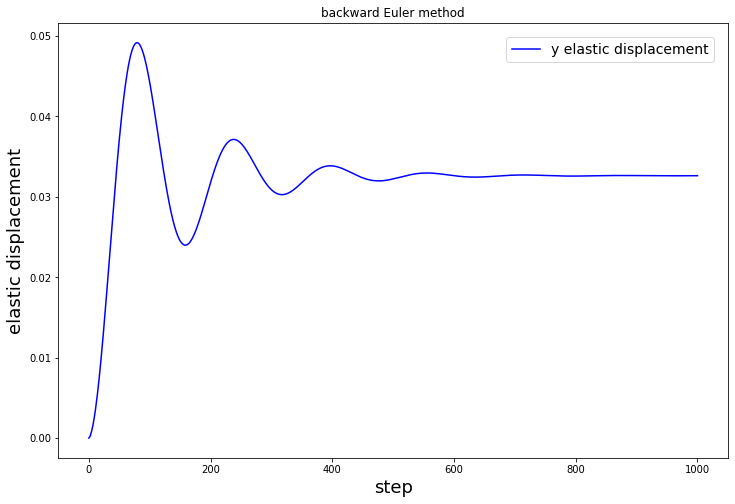

In [187]:
plot_dis(y_dis2_formatted, save=True)

In [174]:
dis2, _, _, _ = main_3d_back('test_verification2.txt')

100 step: 0.138
200 step: 0.250
300 step: 0.382
400 step: 0.508
500 step: 0.635
600 step: 0.762
700 step: 0.888
800 step: 1.016
900 step: 1.153
1000 step: 1.279
1100 step: 1.409
1200 step: 1.541
1300 step: 1.682
1400 step: 1.811
1500 step: 1.960
1600 step: 2.094
1700 step: 2.229
1800 step: 2.355
1900 step: 2.488
2000 step: 2.614
2100 step: 2.745
2200 step: 2.882
2300 step: 3.018
2400 step: 3.155
2500 step: 3.297
2600 step: 3.432
2700 step: 3.566
2800 step: 3.695
2900 step: 3.823
3000 step: 3.973
3100 step: 4.112
3200 step: 4.238
3300 step: 4.370
3400 step: 4.499
3500 step: 4.632
3600 step: 4.767
3700 step: 4.939
3800 step: 5.068
3900 step: 5.207
4000 step: 5.345
4100 step: 5.491
4200 step: 5.625
4300 step: 5.786
4400 step: 5.931
4500 step: 6.073
4600 step: 6.208
4700 step: 6.347
4800 step: 6.488
4900 step: 6.626
5000 step: 6.781
5100 step: 6.934
5200 step: 7.076
5300 step: 7.210
5400 step: 7.368
5500 step: 7.510
5600 step: 7.643
5700 step: 7.796
5800 step: 7.928
5900 step: 8.069
6000 s

44300 step: 63.901
44400 step: 64.044
44500 step: 64.191
44600 step: 64.333
44700 step: 64.476
44800 step: 64.621
44900 step: 64.769
45000 step: 64.913
45100 step: 65.059
45200 step: 65.206
45300 step: 65.349
45400 step: 65.488
45500 step: 65.630
45600 step: 65.776
45700 step: 65.923
45800 step: 66.070
45900 step: 66.215
46000 step: 66.358
46100 step: 66.498
46200 step: 66.636
46300 step: 66.780
46400 step: 66.932
46500 step: 67.077
46600 step: 67.220
46700 step: 67.363
46800 step: 67.501
46900 step: 67.642
47000 step: 67.786
47100 step: 67.934
47200 step: 68.081
47300 step: 68.228
47400 step: 68.371
47500 step: 68.510
47600 step: 68.649
47700 step: 68.798
47800 step: 68.947
47900 step: 69.092
48000 step: 69.237
48100 step: 69.381
48200 step: 69.519
48300 step: 69.660
48400 step: 69.805
48500 step: 69.953
48600 step: 70.102
48700 step: 70.251
48800 step: 70.392
48900 step: 70.534
49000 step: 70.673
49100 step: 70.820
49200 step: 70.969
49300 step: 71.119
49400 step: 71.268
49500 step: 

86500 step: 125.794
86600 step: 125.941
86700 step: 126.086
86800 step: 126.231
86900 step: 126.383
87000 step: 126.524
87100 step: 126.670
87200 step: 126.819
87300 step: 126.966
87400 step: 127.121
87500 step: 127.264
87600 step: 127.406
87700 step: 127.552
87800 step: 127.699
87900 step: 127.852
88000 step: 127.996
88100 step: 128.139
88200 step: 128.282
88300 step: 128.427
88400 step: 128.572
88500 step: 128.718
88600 step: 128.864
88700 step: 129.010
88800 step: 129.156
88900 step: 129.302
89000 step: 129.440
89100 step: 129.588
89200 step: 129.732
89300 step: 129.879
89400 step: 130.025
89500 step: 130.172
89600 step: 130.317
89700 step: 130.456
89800 step: 130.601
89900 step: 130.747
90000 step: 130.894
90100 step: 131.039
90200 step: 131.184
90300 step: 131.332
90400 step: 131.476
90500 step: 131.622
90600 step: 131.769
90700 step: 131.915
90800 step: 132.061
90900 step: 132.208
91000 step: 132.349
91100 step: 132.483
91200 step: 132.618
91300 step: 132.755
91400 step: 132.890


In [183]:
y_dis2 = get_y_dis(dis2)

In [185]:
def format_y_dis(y_dis, b):
    ret = np.zeros((1001), dtype=np.float64)
    for i in range(1, 1001):
        ret[i] = y_dis[i*b]
    return ret        

In [186]:
y_dis2_formatted = format_y_dis(y_dis2, 100)

In [188]:
dis3, _, _, _ = main_3d_back('test_verification2.txt')

/Users/liyuanzhong/.local/share/virtualenvs/jupyter_notebook-7K2ALvDy/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:133: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


100 step: 0.137
200 step: 0.245
300 step: 0.366
400 step: 0.484
500 step: 0.605
600 step: 0.725
700 step: 0.851
800 step: 0.982
900 step: 1.102
1000 step: 1.226
1100 step: 1.353
1200 step: 1.476
1300 step: 1.610
1400 step: 1.741
1500 step: 1.870
1600 step: 1.999
1700 step: 2.128
1800 step: 2.258
1900 step: 2.388
2000 step: 2.517
2100 step: 2.645
2200 step: 2.770
2300 step: 2.895
2400 step: 3.028
2500 step: 3.159
2600 step: 3.284
2700 step: 3.409
2800 step: 3.533
2900 step: 3.660
3000 step: 3.785
3100 step: 3.912
3200 step: 4.038
3300 step: 4.172
3400 step: 4.306
3500 step: 4.438
3600 step: 4.568
3700 step: 4.702
3800 step: 4.827
3900 step: 4.953
4000 step: 5.081
4100 step: 5.209
4200 step: 5.335
4300 step: 5.463
4400 step: 5.590
4500 step: 5.726
4600 step: 5.863
4700 step: 6.003
4800 step: 6.137
4900 step: 6.277
5000 step: 6.418
5100 step: 6.553
5200 step: 6.688
5300 step: 6.824
5400 step: 6.952
5500 step: 7.087
5600 step: 7.218
5700 step: 7.346
5800 step: 7.476
5900 step: 7.611
6000 s

In [189]:
y_dis3 = get_y_dis(dis3)

In [190]:
y_dis3_formatted = format_y_dis(y_dis3, 10)

In [191]:
dis4, _, _, _ = main_3d_back('test_verification2.txt')

/Users/liyuanzhong/.local/share/virtualenvs/jupyter_notebook-7K2ALvDy/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:133: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


100 step: 0.138
200 step: 0.248
300 step: 0.364
400 step: 0.484
500 step: 0.600
600 step: 0.716
700 step: 0.831
800 step: 0.951
900 step: 1.076
1000 step: 1.207
1100 step: 1.337
1200 step: 1.462
1300 step: 1.593
1400 step: 1.719
1500 step: 1.842
1600 step: 1.959
1700 step: 2.079
1800 step: 2.203
1900 step: 2.323
2000 step: 2.445
time: 2.445sec


In [192]:
y_dis4 = get_y_dis(dis4)

In [195]:
y_dis4_formatted = format_y_dis(y_dis4, 2)

In [197]:
dis5, _, _, _ = main_3d_back('test_verification2.txt')

/Users/liyuanzhong/.local/share/virtualenvs/jupyter_notebook-7K2ALvDy/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:133: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


100 step: 0.135
200 step: 0.245
300 step: 0.373
400 step: 0.495
500 step: 0.618
600 step: 0.739
700 step: 0.860
800 step: 0.989
900 step: 1.114
1000 step: 1.239
1100 step: 1.373
1200 step: 1.505
1300 step: 1.637
1400 step: 1.766
1500 step: 1.910
1600 step: 2.040
1700 step: 2.168
1800 step: 2.293
1900 step: 2.423
2000 step: 2.561
2100 step: 2.699
2200 step: 2.830
2300 step: 2.960
2400 step: 3.090
2500 step: 3.220
2600 step: 3.348
2700 step: 3.481
2800 step: 3.608
2900 step: 3.738
3000 step: 3.868
3100 step: 4.006
3200 step: 4.139
3300 step: 4.273
3400 step: 4.399
3500 step: 4.533
3600 step: 4.665
3700 step: 4.795
3800 step: 4.928
3900 step: 5.082
4000 step: 5.226
4100 step: 5.366
4200 step: 5.503
4300 step: 5.635
4400 step: 5.765
4500 step: 5.902
4600 step: 6.043
4700 step: 6.185
4800 step: 6.320
4900 step: 6.465
5000 step: 6.593
time: 6.593sec


In [198]:
y_dis5 = get_y_dis(dis5)

In [200]:
y_dis5_formatted = format_y_dis(y_dis5, 5)

In [204]:
data = {
    'step1000': y_dis,
    'step2000': y_dis4_formatted,
    'step5000': y_dis5_formatted,
    'step10000': y_dis3_formatted,
    'step100000': y_dis2_formatted
}

In [205]:
with open('後退オイラー法精度テストデータ1', 'wb') as f:
    pickle.dump(data, f)